训练误差: 模型在训练数据上的误差
泛化误差: 模型在新数据上的误差

验证数据集: 验证模型好坏, 比如分出50%的训练数据（这样对数据集的消耗比较大）不参加训练, 反应超参数选择的好坏
测试数据集: 只用一次的数据集, 比如考试、实际价格、kaggle；也许模型投入使用时的数据（模拟考和高考的区别）

K-折交叉验证：在没有足够多数据的时候使用（数据不够是常态）
算法：
将训练数据分割为K块；
此后我们进行K次运算，对于第i次运算，我们选取第i块为验证数据集，其余作为训练数据；
最后我们报告K个验证集误差的平均；
常用的K取值：K=5, K=10

模型的过拟合和欠拟合：复杂的模型需要学习复杂的函数
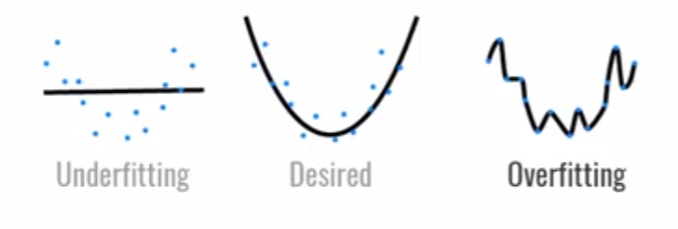
欠拟合：理解不了大量的数据
过拟合：模型太强，直接记住了所有的数据，没有预测性了
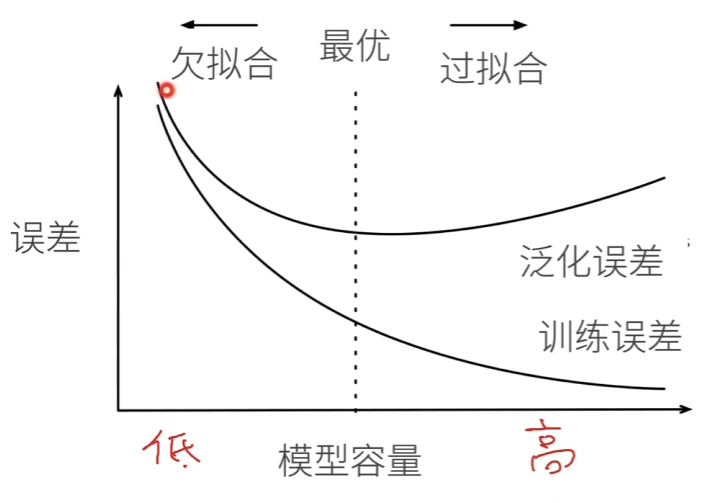
找到使得泛化误差下降的最优区间

VC维（深度学习中用得少）：一个分类模型对于一个k维的数据集，不管如何给定标号，都存在一个模型可以对其完美分类；这个k维被称作VC维：比如2维输入的感知机，VC维就是3（不能解决4维的XOR问题）
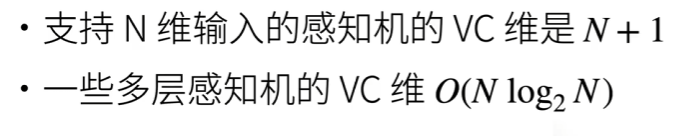

正则化（Regularization）是通过向损失函数添加额外项（即正则项）来约束模型复杂度的技术。

使用均方范数硬性限制模型容量:
在 |w|^2 <= θ 时 确定最小的损失l(w, b)
小的θ意味着更强的正则项

使用均方范数柔性限制模型容量:
可以证明, 对于上文的每一个θ, 都可以找到一个λ, 使得之前的目标函数(θ限制下的min(l(w, b))等价于 min(l(w, b)) + λ*|w|^2/2)
λ越大，正则项的惩罚力度越强(对w大小的惩罚)，间接迫使参数w变得更小，模型更简单
上式中, 超参数λ控制了正则项的重要程度

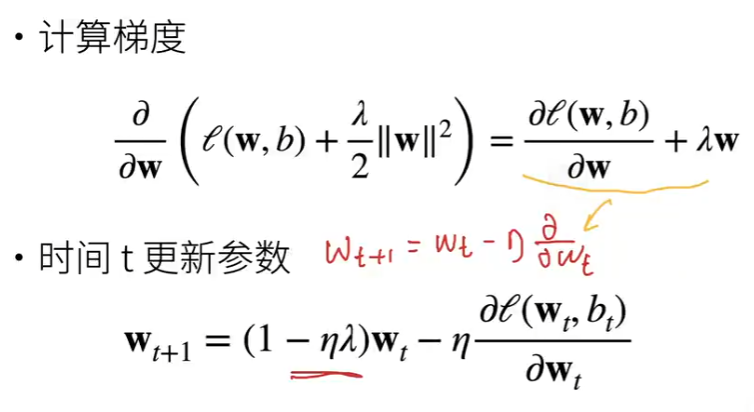
其中1-ηλ一般在0-1中, 相当于放小了w的权重, 就称为权重衰退

In [ ]:
# 权重衰退的实现
%matplotlib
import torch
from torch import nn
from d2l import torch as d2l

生成一个人工数据集: 线性回归问题
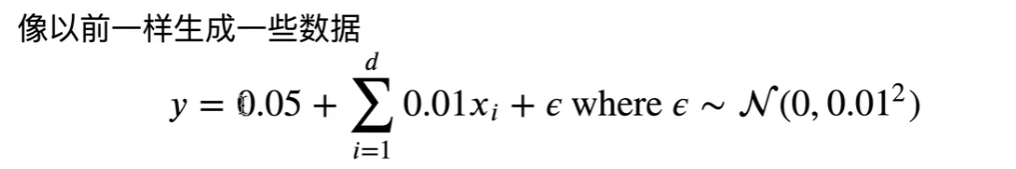

In [ ]:
# 生成数据集, 确定真实的w, b
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [ ]:
# 初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 定义范数惩罚 λ*|w|^2/2 (其中, λ后面单独定义, 这里没写进去)
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [ ]:
#训练
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # 改变了损失l的算法
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

In [ ]:
# λ为0时训练函数的损失一直下降, 但是测试时的损失一直不变
# 也就是出现了过拟合
train(lambd=0)

In [ ]:
# 简洁实现
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
         # 多出来的项直接写到训练过程中, 而不是在目标函数中定义了再加入
        'weight_decay': wd}, {
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

一个好的模型需要对输入数据的扰动呈现稳定性
丢弃法: 在层之间加入噪音; 对每个元素施加扰动: 有p的概率, x'=0, else x'=x/1-p

丢弃法的本质是正则化, 正则化只在训练中使用: 正则化的本质是约束参数更新, 说白了也只是得到更好用的模型的一种手段.
正则化的好处: 防止过拟合、提升泛化能力、稳定优化过程、平衡模型复杂度。
丢弃法: 防止过拟合、 随机“关闭”部分神经元，模拟了多个子网络的集成效果，提升了泛化能力、打破神经元之间的强依赖关系，迫使每个神经元独立学习有用特征，而非依赖其他神经元的结果。

In [ ]:
# 丢弃法的代码实现
import torch
from torch import nn
from d2l import torch as d2l

# 传入X和概率p
def dropout_layer(X, dropout):
    # 特殊情况处理：全丢和不丢
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    # 生成一个0-1的随机分布，大于p的化为一，反之为0
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    # 相乘后剩下被选中的数，在进行/(1-p)
    return mask * X / (1.0 - dropout)

In [ ]:
# 定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

# 主要区别: 根据是否正在训练决定是否作用dropout
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [ ]:
# 训练和测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
# 简洁实现: 不用自己定义了, 调用函数即可
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
                    nn.Dropout(dropout2), nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

神经网络的梯度:
对于一个有d层的神经网络, t层输出h/t/ = f(h/t-1/)
如果我们想计算损失l关于Wt的梯度: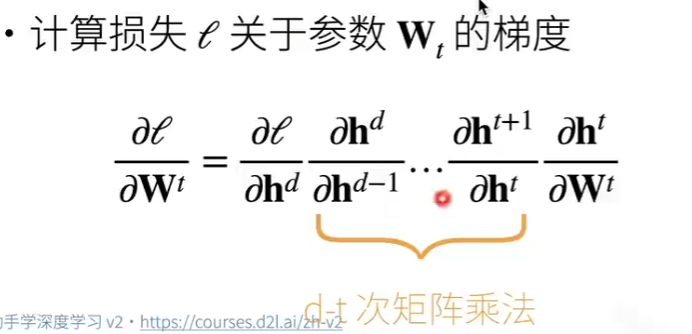
每次求梯度之后相乘, 相当于我们做了d-t次矩阵乘法,每次乘数的大小,取决于我们选取的激活函数, 如果我们乘的次数太多, 很容易出现梯度爆炸和梯度消失的情况

梯度爆炸的问题:
1.超出值域
2.学习率敏感, 如果学习率太大的话, 就容易梯度爆炸;我们可能需要动态的调整学习率
梯度消失的问题:
1.梯度变为0
2.训练没有进展
3.无法让神经网络更深(越深处, 历经的矩阵乘法更多)

模型初始化和梯度函数:
需要让模型更加稳定: 合理的梯度值, 矩阵乘法变加法, 梯度归一化/裁剪, 选取合理的初始权重和激活函数

目的: 让每层的输出和梯度的均值和方差保持一致
权重初始化: 远离最优解地方的损失函数表面可能很复杂, 最优解附近的表面可能比较平滑. 如何选取一个不错的初始化值呢, 在我们的期望中, 对于每层的输出和梯度, 我们将他们看做随机变量, 希望他们的均值和方差都保持一直: 均值为0, 方差为常数
接下来就是概率论公式推导: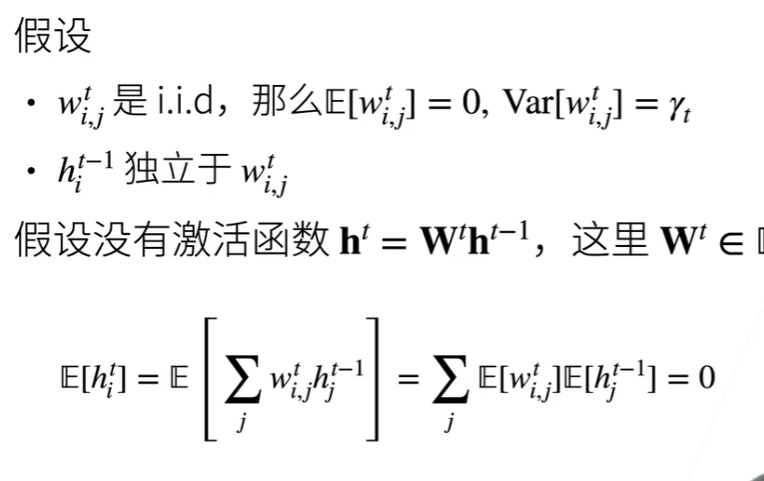

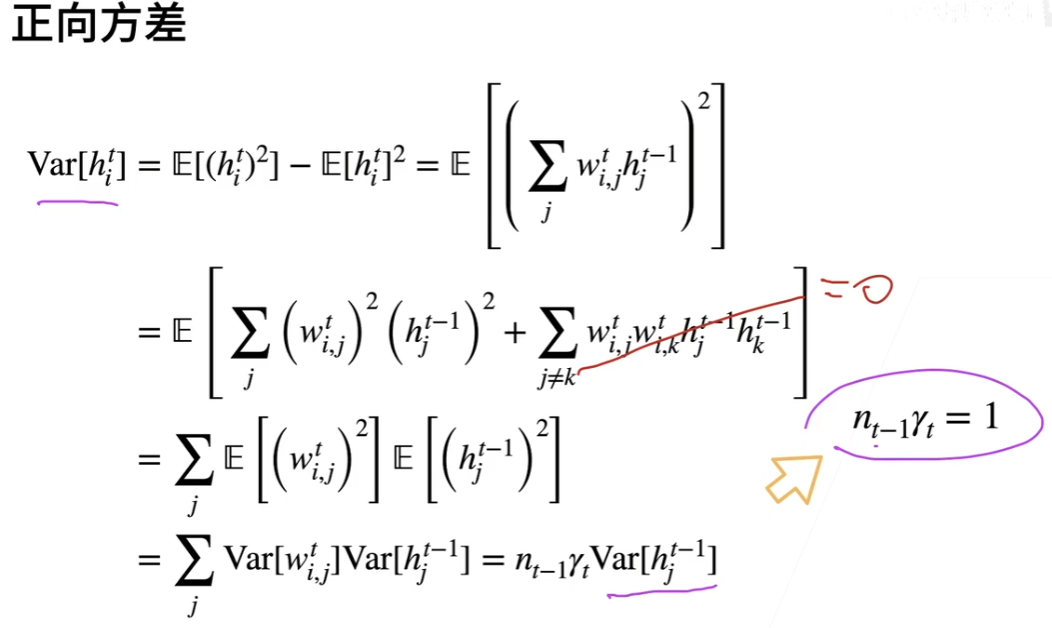
独立同分布等概率论常见推导:最后求和后t-1个方差乘积为常数, 那么就是t-1*w方差为1

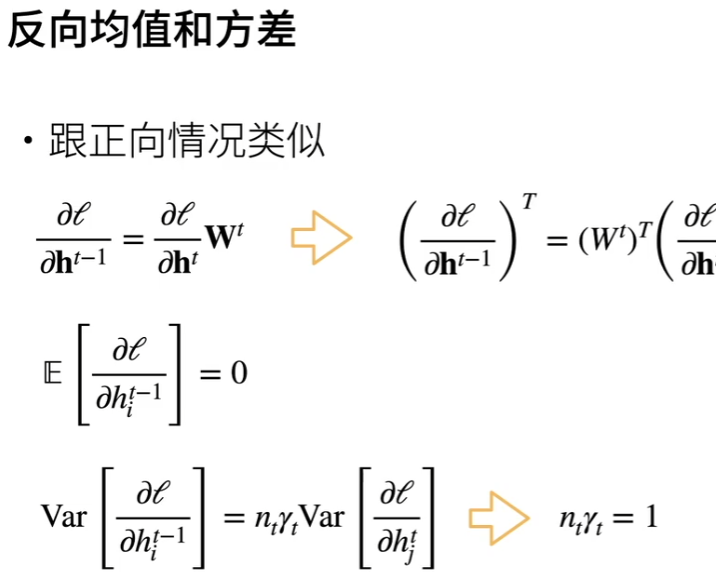
反向得到类似结论, 唯一差别是nt和nt-1

很明显这两个结论不能同时满足, 所以选取了一个折中的方法:Xavier初始
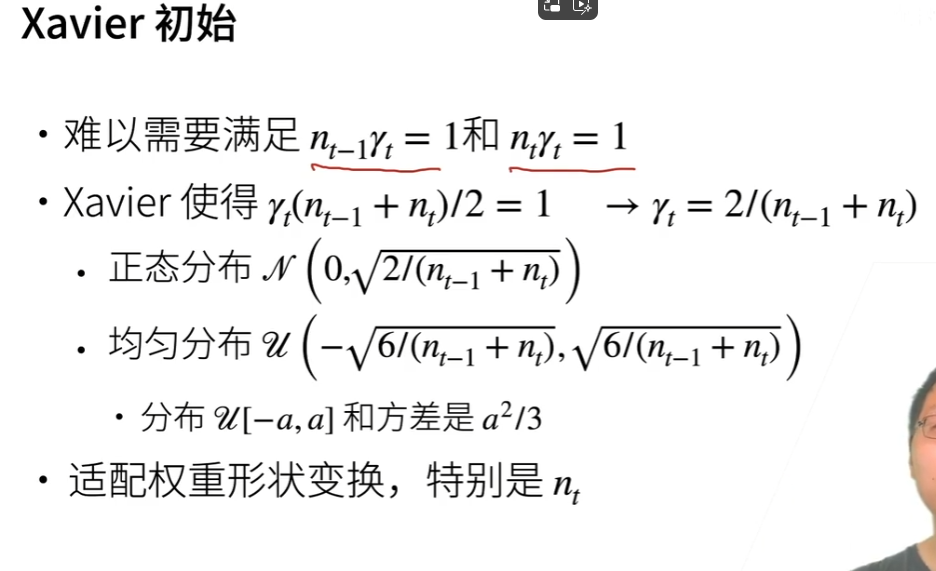

接下来, 我们看看怎么样让激活函数尽量满足这种条件:
假设一个线性激活函数, 代入此条件:
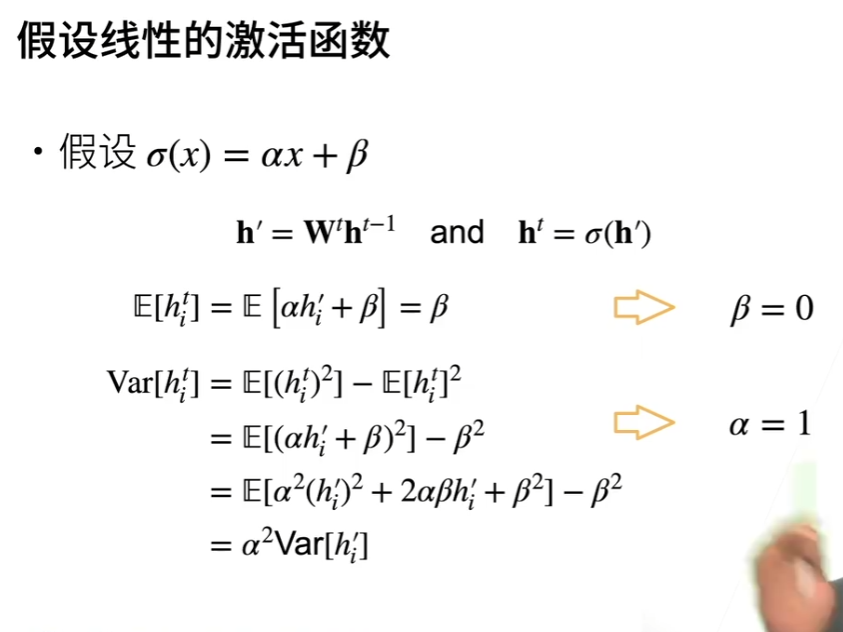
发现α和β分别为1和0(反向结论相同)
又由于激活函数不是线性的, 我们用泰勒展开模拟, 发现tanh和relu都大致满足条件, sigmoid可以调整的更好
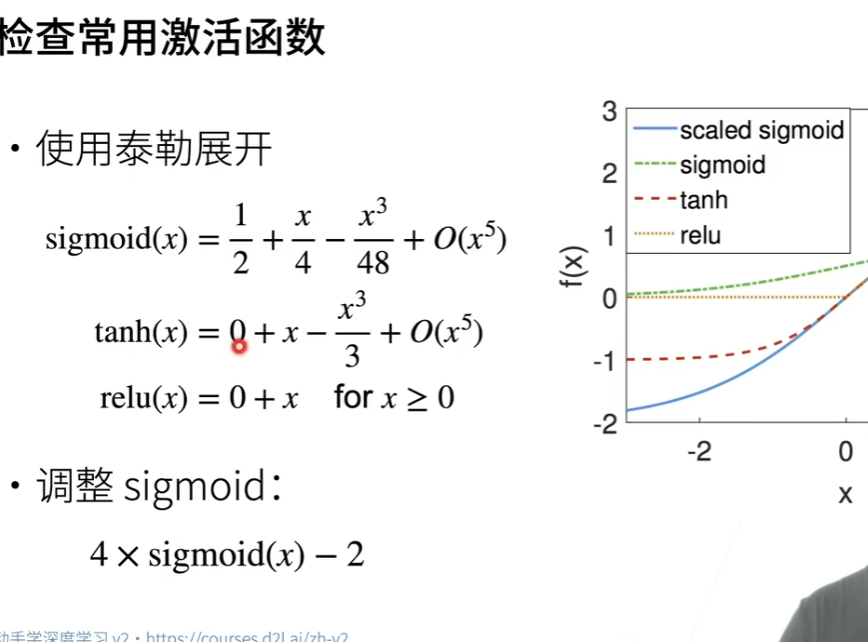

这样我们进行合理的权重初始化, 可以达到提升数值稳定性的效果